In [1]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [45]:
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [2]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
def cv_optimize(clf, parameters, X,y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds,
                          n_jobs=n_jobs, scoring= score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds,
                          n_jobs=n_jobs)
    gs.fit(X, y)
    print("Best", gs.best_params_, gs.best_score_, gs.grid_scores_)
    best = gs.best_estimator_
    return best

def do_classify(clf, parameters, indf, featurenames, targetname,
               target1val, mask=None, reuse_split = None,
               score_func =None, n_folds=5, n_jobs=1):
    subdf = indf[featurenames]
    X = subdf.values
    y = (indf[targetname].values == target1val)*1
    if mask != None:
        print("Using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split != None:
        print("Using resuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'],reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs,
                         n_folds = n_folds, score_func = score_func)
    clf = clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest

In [4]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [5]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1, prob=True):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    if prob:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

In [6]:
dfhw=pd.read_csv("https://dl.dropboxusercontent.com/u/75194/stats/data/01_heights_weights_genders.csv")
dfhw.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [7]:
dfhw.shape

(10000, 3)

In [8]:
df = dfhw.sample(500, replace=False)
np.sum(df.Gender =="Male")

249

In [9]:
itrain, itest = train_test_split(list(range(df.shape[0])), train_size=0.6)
mask = np.ones(df.shape[0], dtype="int")
mask[itrain] = 1
mask[itest] = 0
mask = (mask == 1)
mask[:10]

array([False,  True,  True,  True, False, False,  True, False,  True,  True], dtype=bool)

### Logistic Regression L2 regularized 

In [10]:
%matplotlib inline

C:\Users\Kunal\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Using mask
Best {'C': 0.01} 0.943333333333 [mean: 0.93000, std: 0.01968, params: {'C': 0.001}, mean: 0.94333, std: 0.01336, params: {'C': 0.01}, mean: 0.94000, std: 0.01731, params: {'C': 0.1}, mean: 0.94333, std: 0.01733, params: {'C': 1}, mean: 0.94333, std: 0.01733, params: {'C': 10}, mean: 0.94333, std: 0.01733, params: {'C': 100}, mean: 0.93667, std: 0.01289, params: {'C': 1000}, mean: 0.93667, std: 0.01289, params: {'C': 10000}]
############# based on standard predict ################
Accuracy on training data: 0.94
Accuracy on test data:     0.91
[[95 12]
 [ 6 87]]
########################################################


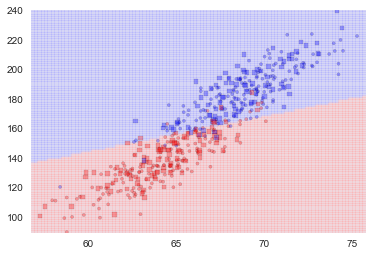

In [11]:
from sklearn.linear_model import LogisticRegression
clflog = LogisticRegression()
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
clflog, Xtrain, ytrain, Xtest, ytest=do_classify(clflog, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog);

In [12]:
clflog.predict(Xtest)

array([0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1])

In [13]:
clflog.predict_proba(Xtest)

array([[  8.28600750e-01,   1.71399250e-01],
       [  9.83592326e-01,   1.64076739e-02],
       [  8.34269162e-03,   9.91657308e-01],
       [  5.12159164e-02,   9.48784084e-01],
       [  5.52732286e-01,   4.47267714e-01],
       [  2.81244175e-01,   7.18755825e-01],
       [  2.74257546e-01,   7.25742454e-01],
       [  7.26462873e-01,   2.73537127e-01],
       [  1.75205476e-02,   9.82479452e-01],
       [  9.71891638e-01,   2.81083615e-02],
       [  6.69372099e-03,   9.93306279e-01],
       [  1.61363723e-03,   9.98386363e-01],
       [  3.46929573e-03,   9.96530704e-01],
       [  1.29895132e-01,   8.70104868e-01],
       [  1.60707928e-02,   9.83929207e-01],
       [  8.96475502e-01,   1.03524498e-01],
       [  8.62738860e-01,   1.37261140e-01],
       [  3.53695794e-03,   9.96463042e-01],
       [  6.79321113e-01,   3.20678887e-01],
       [  9.78403359e-01,   2.15966408e-02],
       [  4.86742229e-03,   9.95132578e-01],
       [  8.05139302e-01,   1.94860698e-01],
       [  

(array([ 58.,  15.,  11.,  11.,   6.,   6.,   8.,  10.,  14.,  61.]),
 array([  4.31328732e-02,   1.00385579e+01,   2.00339829e+01,
          3.00294080e+01,   4.00248330e+01,   5.00202581e+01,
          6.00156831e+01,   7.00111081e+01,   8.00065332e+01,
          9.00019582e+01,   9.99973833e+01]),
 <a list of 10 Patch objects>)

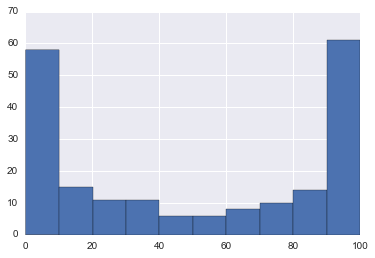

In [14]:
plt.hist(clflog.predict_proba(Xtest)[:,1]*100)

### SVM 

C:\Users\Kunal\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Using mask
Best {'C': 1} 0.94 [mean: 0.91667, std: 0.04070, params: {'C': 0.001}, mean: 0.93000, std: 0.02598, params: {'C': 0.01}, mean: 0.93000, std: 0.01285, params: {'C': 0.1}, mean: 0.94000, std: 0.00856, params: {'C': 1}, mean: 0.93667, std: 0.01272, params: {'C': 10}, mean: 0.93667, std: 0.01272, params: {'C': 100}, mean: 0.93667, std: 0.01272, params: {'C': 1000}]
############# based on standard predict ################
Accuracy on training data: 0.93
Accuracy on test data:     0.91
[[95 12]
 [ 7 86]]
########################################################


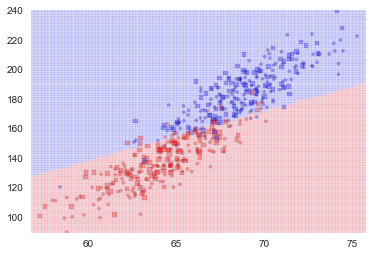

In [15]:
from sklearn.svm import SVC
clfsvm = SVC(kernel="linear")
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
clfsvm, Xtrain, ytrain, Xtest, ytest=do_classify(clfsvm, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);

In [16]:
clfsvm.decision_function(Xtest)

array([ -1.53708575,  -3.91146379,   5.45321648,   2.53207675,
         0.37908714,   1.39863316,   0.7643068 ,  -1.32634932,
         4.251455  ,  -3.80710914,   4.79150923,   7.17053737,
         6.71591711,   1.6410808 ,   4.27553329,  -2.23888301,
        -1.58052705,   6.16974673,  -1.11515563,  -4.2932016 ,
         5.61031687,  -1.30151648,   5.95005294,  -6.05201631,
         6.06967553,   1.90417574,  -0.07645957,  -1.44275391,
         0.9644531 ,  -3.68431406,   6.29094391,  -3.74584497,
        -4.10311983,  -2.82905022,   5.85082524,  -0.4129679 ,
         4.33607019,   3.5067874 ,   3.68381007,   0.46701942,
        -0.11764869,   0.18518201,  -2.20862615,   6.72798877,
        -2.06120994,   8.50007075,  -4.17472353,   1.0231992 ,
        -1.97369383,  -0.68549746,  -0.91977062,   5.96502209,
        -4.94333362,   0.13344448,   2.76753497,  -5.58623644,
        -4.72896256,  -0.31381365,   3.30016801,   5.41062177,
        -1.77357816,  -4.00304695,  -4.49364422,  -0.54

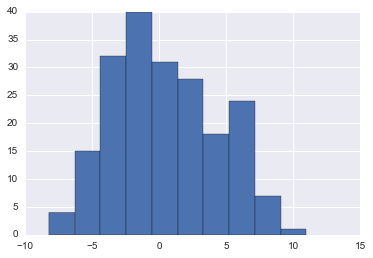

In [17]:
plt.hist(clfsvm.decision_function(Xtest));

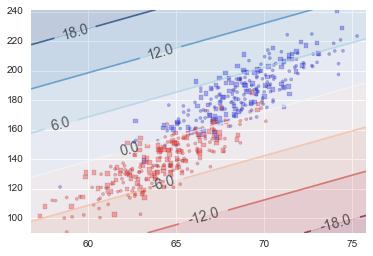

In [18]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, mesh=False);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, prob=False);

In [19]:
def plot_svc_decision_function(clf, ax=None):
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y,x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i,j] = clf.decision_function([xi,yj])
    return ax.contour(X, Y, P, colors="k", levels=[-1,0,1],
                     alpha=0.5, linesyles=['--','-','--'])

C:\Users\Kunal\Anaconda3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\Kunal\Anaconda3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\Kunal\Anaconda3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning

(125, 225)

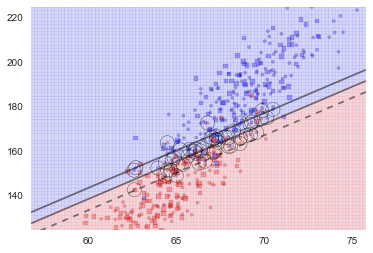

In [20]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);
plot_svc_decision_function(clfsvm, ax)
ax.scatter(clfsvm.support_vectors_[:, 0], clfsvm.support_vectors_[:, 1],s=200, facecolors='none')
plt.ylim([125,225])

#### Confusion Matrix 

In [21]:
confusion_matrix(ytest, clflog.predict(Xtest))

array([[95, 12],
       [ 6, 87]])

In [22]:
from sklearn.metrics import classification_report
print(classification_report(ytest,clflog.predict(Xtest)))

             precision    recall  f1-score   support

          0       0.94      0.89      0.91       107
          1       0.88      0.94      0.91        93

avg / total       0.91      0.91      0.91       200



### Changing Threshold for log regression 

In [34]:
def t_repredict(est, t ,xtest):
    probs = est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [35]:
confusion_matrix(ytest, t_repredict(clflog, 0.1,Xtest))

array([[57, 50],
       [ 1, 92]])

In [36]:
from sklearn.metrics import roc_curve, auc

In [49]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

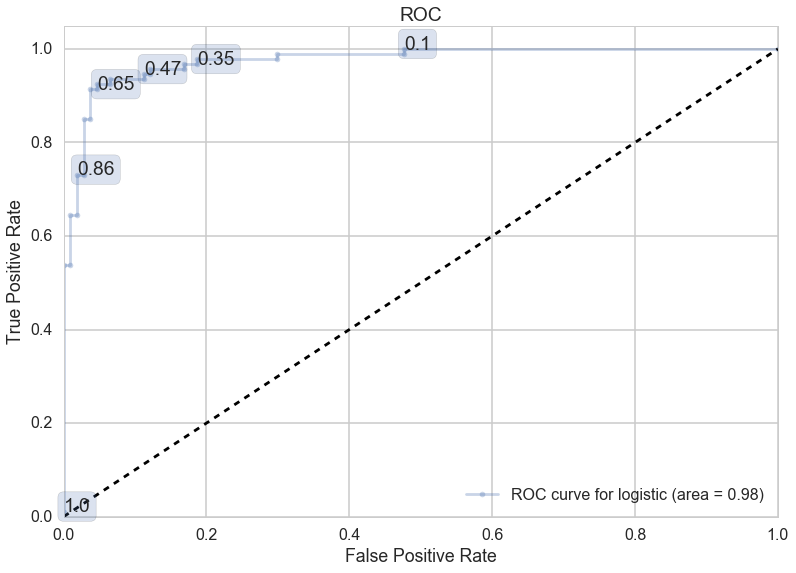

In [52]:
make_roc("logistic", clflog, ytest, Xtest, labe=5)

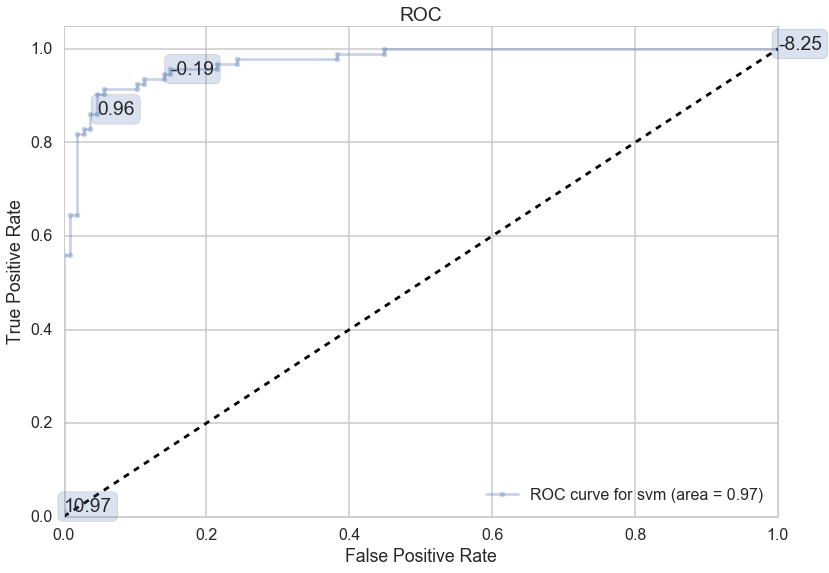

In [51]:
make_roc("svm", clfsvm, ytest, Xtest, labe=10, proba=False)